In [1]:
#imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import shap 
import lime
import torch
from sentence_transformers import SentenceTransformer as st
import sklearn as sk
import imblearn



# Globals


In [2]:
# load the data
base_claims_df = pd.read_csv('data/anno_claims.csv')
pd.set_option('display.max_columns', None)

# load the sentence transformer model
st_model = st("all-MiniLM-L6-v2")

Yes_No_Columns = ['Exceptional_Circumstances', 'Minor_Psychological_Injury', 'Whiplash', 'Police Report Filed', 'Witness Present']
Categorical_Columns = ['AccidentType', 'Dominant injury', 'Vehicle Type', 'Weather Conditions', 'Accident Description', 'Injury Description']


test_headder = 'SettlementValue'

impution_dic = { ## used to store which header needs to be imputed and which do not.
    'needed': [
        'AccidentType',
        'GeneralFixed',
        'Minor_Psychological_Injury',
        'Dominant injury',
        'Whiplash',
        'Weather Conditions',
        'Accident Description',
    ],
    'not_needed': [ ## these are columns which are no input could be used as a form of imput; meaning they are not applicable to the situation and were left blank for a reason.
        'Injury_Prognosis', ## should be defaulted to Z. 0 months
        'SpecialHealthExpenses', ## should be defaulted to 0.0 as not everyone has health expenses
        'SpecialReduction', ## should be defaulted to 0.0 as not everyone has reduction
        'SpecialOverage', ## should be defaulted to 0.0 as not everyone has overage
        'GeneralRest', ## should be defaulted to 0.0 as not everyone has rest
        'SpecialAdditionalInjury', ## should be defaulted to 0.0 as not everyone has additional injury
        'SpecialEarningsLoss', ## should be defaulted to 0.0 as not everyone has earnings loss
        'SpecialUsageLoss', ## should be defaulted to 0.0 as not everyone has usage loss
        'SpecialMedications', ## should be defaulted to 0.0 as not everyone has medications
        'SpecialAssetDamage', ## should be defaulted to 0.0 as not everyone has asset damage
        'SpecialRehabilitation', ## should be defaulted to 0.0 as not everyone has rehabilitation
        'SpecialFixes', ## should be defaulted to 0.0 as not everyone has fixes
        'GeneralUplift', ## should be defaulted to 0.0 as not everyone has uplift
        'SpecialLoanerVehicle', ## should be defaulted to 0.0 as not everyone has loaner vehicle
        'SpecialTripCosts', ## should be defaulted to 0.0 as not everyone has trip costs
        'SpecialJourneyExpenses', ## should be defaulted to 0.0 as not everyone has journey expenses
        'SpecialTherapy', ## should be defaulted to 0.0 as not everyone has therapy
        'Exceptional_Circumstances', ## should be defaulted to False as not everyone has exceptional circumstances
        'Number of Passengers', ## should be defaulted to 0 as not everyone has passengers
        'Injury Description', ## No input could be used as a form of imput; meaning they are not applicable to the situation and were left blank for a reason.
        'Police Report Filed', ## No input could be used as a form of imput; meaning they are not applicable to the situation and were left blank for a reason.
        'Witness Present', ## No input could be used as a form of imput; meaning they are not applicable to the situation and were left blank for a reason
    ],
    'drop': { ## these are columns which should be droppped if they are null as their values are highly correlated with the settlement value
        'SettlementValue',
        'Vehicle Age',
        'Vehicle Type',
        'Driver Age',
        'Accident Date',
        'Claim Date',
    }
}

# Creating Helper Functions
These are useful for easily tranforming a sentence or column into embedded strings, capturing meaning behind words instead of just using a numerical value for the "category".

In [3]:

def encode_text(text):
    return st_model.encode(text, convert_to_tensor=True)


def transform_columns_to_embeddings(df, column_name):

    ids_to_string = {} # integer: string
    string_ids = {} # string: integer

    unique_column_values = df[column_name].unique()
    for index, value in enumerate(unique_column_values):
        if isinstance(value, str):
            string_ids[value] = index
            ids_to_string[index] = value
        else:
            print(f"Skipping non-string value: {value}")


    # Check if the column exists in the DataFrame
    embeddings = {} # hash(value): [embedding]
    strings = {} # hash(value): string
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' does not exist in the DataFrame.")

    # Iterate through the DataFrame and encode the specified column
    unique_column_values = df[column_name].unique()
    for value in unique_column_values:
        if isinstance(value, str):  # Ensure the value is a string before encoding
            embedding = encode_text(value)

            ## convert embedding to an array of floats
            embedding = np.array(embedding.cpu()).astype(np.float32).tolist()

            embeddings[hash(value)] = embedding
            strings[hash(value)] = value
        else:
            print(f"Skipping non-string value: {value}")


    df_returns = df.copy()
    ## Convert the column to string indexes
    df_returns[column_name] = df_returns[column_name].apply(lambda x: string_ids.get(x, x))  # Use the string_ids mapping to convert to indexes

    return df_returns, embeddings, strings, ids_to_string

## Example usage
# anno_claims_df, embeddings, strings = transform_columns_to_embeddings(anno_claims_df, 'AccidentType')
# for key, value in embeddings.items():
#     print(f"Key: {key}, String: {strings[key]}")
#     print(f"Embedding shape: {value.shape}")
#     print(f"Embedding: {value}")
#     print("-----")

# Processing Data


## Pre-Pre-Processing
This is where the pre-processing for the pre-processing happens. This includes refactoring the dataframe for analysis regarding pre-processing, for example dropping rows without SettlementValues and refactoring Exceptional_Circumstances to a binary True/False instead of a linguistic Yes/no.

In [4]:
def replace_yes_no_with_binary(df, column_names):
    """
    Replace 'Yes' and 'No' with 1 and 0 in the specified column of the DataFrame.
    """
    df_cpy = df.copy()
    df_cpy = df_cpy.dropna(subset=['SettlementValue'])


    ## replace Yes/No with True/False in the Yes_No columns
    for col in column_names:
        df_cpy[col] = df_cpy[col].replace({'Yes': 1.0, 'No': 0.0})
        # anno_claims_df[col] = anno_claims_df[col].astype('Int64')  # Convert to integer type

    return df_cpy

In [5]:
def replace_categorical_with_ints(df, column_names):
    """
    Replace categorical values with binary values in the specified column of the DataFrame.
    """
    df_cpy = df.copy()

    all_embeddings = {}
    all_embedded_strings = {}
    all_ids_to_string = {}
    ## convert the categorical columns to their hash values and embeddings
    for col in column_names:
        df_cpy, embeddings, strings, id_to_string = transform_columns_to_embeddings(df_cpy, col)

        all_embeddings.update(embeddings)
        all_embedded_strings.update(strings)

        if col not in all_ids_to_string:
            all_ids_to_string[col] = id_to_string
        else:
            all_ids_to_string[col].update(id_to_string)

    
    return df_cpy, all_embeddings, all_embedded_strings, all_ids_to_string


In [6]:
def map_genders(df, column_name):
    df_cpy = df.copy()

    mapped_gender = {}
    unique_values = df_cpy[column_name].unique()
    ##remove any null values from the unique values
    unique_values = unique_values[~pd.isnull(unique_values)]
    for i, value in enumerate(unique_values):
        mapped_gender[i] = value
        df_cpy[column_name] = df_cpy[column_name].replace(value, i)
    return df_cpy, mapped_gender

In [7]:
def convert_to_seconds(df, column_name):
    df_cpy = df.copy()
    # Check if the column exists in the DataFrame
    if column_name not in df_cpy.columns:
        raise ValueError(f"Column '{column_name}' does not exist in the DataFrame.")
    
    # duplicate the column to avoid overwriting the original data
    df_cpy[column_name + '_time'] = df_cpy[column_name]
    # convert the original column to the day of the year (x/365)
    df_cpy[column_name] = pd.to_datetime(df_cpy[column_name], errors='coerce').dt.dayofyear
    # convert the time to seconds since start of the day (00:00:00)
    df_cpy[column_name + '_time'] = pd.to_datetime(df_cpy[column_name + '_time'], errors='coerce')
    df_cpy[column_name + '_time'] = df_cpy[column_name + '_time'].apply(
        lambda x: (x.hour * 3600 + x.minute * 60 + x.second) if pd.notnull(x) else 0
    )

    # convert the column to a float type
    df_cpy[column_name + '_time'] = df_cpy[column_name + '_time'].astype(float)

    return df_cpy


In [8]:
def convert_to_seconds_diff(df, col1, col2):
    df_cpy = df.copy()
    # Check if the columns exist in the DataFrame
    if col1 not in df_cpy.columns or col2 not in df_cpy.columns:
        raise ValueError(f"Columns '{col1}' or '{col2}' do not exist in the DataFrame.")

    # convert the columns to datetime
    df_cpy[col1] = pd.to_datetime(df_cpy[col1], errors='coerce')
    df_cpy[col2] = pd.to_datetime(df_cpy[col2], errors='coerce')

    # calculate the difference between the two columns
    df_cpy['days_diff'] = (df_cpy[col2] - df_cpy[col1]).dt.days.fillna(0).astype(int)

    # seconds_diff should be time from the start of the day (00:00:00)
    df_cpy['seconds_diff'] = df_cpy[col2].apply(
        lambda x: (x.hour * 3600 + x.minute * 60 + x.second) if pd.notnull(x) else 0
    )

    return df_cpy['days_diff'], df_cpy['seconds_diff']


In [9]:
def fix_prognosis(df, column_name):
    df_cpy = df.copy()
    # Check if the column exists in the DataFrame
    if column_name not in df_cpy.columns:
        raise ValueError(f"Column '{column_name}' does not exist in the DataFrame.")
    
    # convert extract the month from the column (D. 4 months) -> 4
    df_cpy[column_name] = df_cpy[column_name].str.extract(r'(\d+)')[0].astype(float)
    # convert the column to numeric values
    df_cpy[column_name] = pd.to_numeric(df_cpy[column_name], errors='coerce')


    return df_cpy

In [10]:
def pre_pre_processing(df, yes_no_columns, categorical_columns):

    df_cpy = df.copy()

    ## replace the Yes/No columns with 1/0
    df_cpy = replace_yes_no_with_binary(df_cpy, yes_no_columns)

    ## replace the categorical columns with their hash values and embeddings
    df_cpy, all_embeddings, all_embedded_strings, all_ids_to_string = replace_categorical_with_ints(df_cpy, categorical_columns)

    df_cpy, gender_mapping = map_genders(df_cpy, 'Gender')


    df_cpy['Claim_Delay'], df_cpy['Claim_Delay_Time'] = convert_to_seconds_diff(df_cpy, 'Accident Date', 'Claim Date')  
    # drop claim date as it is no longer relevant as more meaningful data has been created from it
    df_cpy = df_cpy.drop(columns=['Claim Date'])

    df_cpy = convert_to_seconds(df_cpy, 'Accident Date')

    # fix the prognosis column to be numeric values
    df_cpy = fix_prognosis(df_cpy, 'Injury_Prognosis')

    return df_cpy, all_embeddings, all_embedded_strings, all_ids_to_string, gender_mapping


## Pre-Processing
This is where the data is imputed and duplicated to create more examples for training against different low-seen examples.

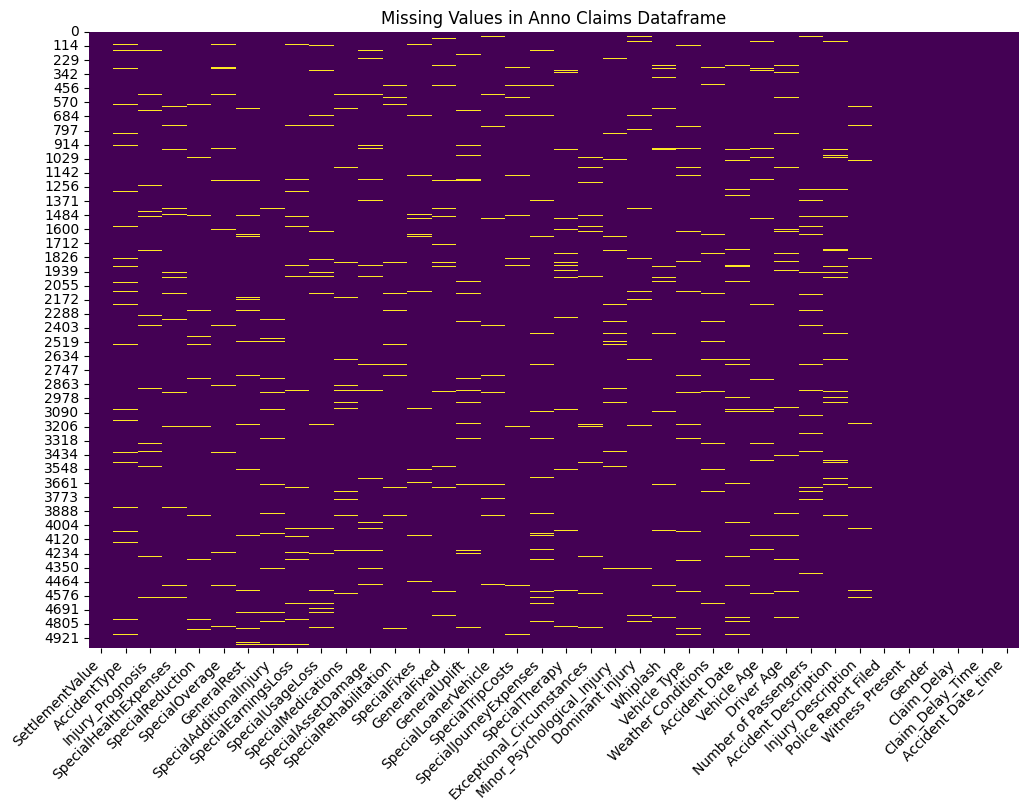

In [13]:
## seaborn heatmap of the missing values in the dataframe
plt.figure(figsize=(12, 8))
sns.heatmap(processed_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in Anno Claims Dataframe')
##xticks at 45 degree angle
plt.xticks(rotation=45, ha='right')
plt.show()

In [14]:
def impute_column_with_mlp(df, target_col):


    df_cpy = df.copy()
    
    if target_col not in df_cpy.columns:
        return df

    clean = df_cpy.dropna()
    # drop the tareget column from the dataframe
    Y = clean[target_col]
    X = clean.drop(columns=[target_col])


    ## split the data into train and test sets
    from sklearn.model_selection import train_test_split
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


    # print unique values in the target column
    print("Unique values in target column: ", Y_train.unique())
    print("Unique values in target column: ", len(Y_train.unique()))


    # Create and train the MLP model

    model_params = None
    model_opt = None
    model_compile = None
    callbacks = []
    # Define the model architecture
    if target_col in Yes_No_Columns:
        model_params = tf.keras.layers.Dense(1, activation='sigmoid')

        model_opt = tf.keras.optimizers.Adam(learning_rate=0.01)
        
        # compile docs state the order as (self, optimizer, loss, loss_weights, metrics, ...)
        model_compile = (model_opt, 'binary_crossentropy',['accuracy']) 

        callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True))


    elif target_col in Categorical_Columns:
        model_params = tf.keras.layers.Dense(len(df[target_col].unique()), activation='softmax')
        

        model_opt = tf.keras.optimizers.Adam(learning_rate=0.01)
        model_compile = (model_opt, 'sparse_categorical_crossentropy',['accuracy'])
        callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True))
        
    else:
        model_params = tf.keras.layers.Dense(1, activation='linear')
        model_opt = tf.keras.optimizers.Adam(learning_rate=0.01)
        model_compile = (model_opt, 'mean_squared_error', ['mean_absolute_error'])
        callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True))
        
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        model_params
        
    ])
    model.compile(optimizer=model_compile[0], loss=model_compile[1], metrics=model_compile[2])


    model.fit(X_train, Y_train, epochs=100, batch_size=16, validation_split=0.2, verbose=1, callbacks=callbacks) #, class_weight=class_weights

    ## print the mse and mae of the model using keras
    X_pred = model.predict(X_test)

    if target_col in Categorical_Columns:
        X_pred = np.argmax(X_pred, axis=1)


    # # Impute missing values in the target column using the trained model
    for index, row in df_cpy.iterrows():
        if not pd.isnull(row[target_col]):
            continue

        ## set the row's target column to predicted value
        pred = model.predict(row.drop(target_col).values.reshape(1, -1))
        df_cpy.at[index, target_col] = np.argmax(pred, axis=1)
        
    return df_cpy


In [15]:
def impute_data(df, dic):
    df_cpy = df.copy()

    ## clean the data by dropping any rows with null values 


    ### loop through the columns and drop rows with null values
    for col in dic['drop']:
        if col not in df_cpy.columns:
            continue
        ## check if the column exists in the DataFrame
        if df_cpy[col].isnull().sum() > 0: 
            df_cpy = df_cpy.dropna(subset=[col])


    ## loop # rough the not needed columns and im# te them manually, treating null values in a float as 0.0, n# l binary values as False, integer as 0
    for col in dic['not_needed']:
        # col in df_cpy.columns:
        # check if the colu#  exists in the DataFrame
        if df_cpy[col].isnull().sum() == 0:  # Only impute if there are null values
            continue
        if col not in df_cpy.columns:
            continue

        if df_cpy[col].dtype == 'float64':
            df_cpy[col] = df_cpy[col].fillna(0.0)
        elif df_cpy[col].dtype == 'int32':
            df_cpy[col] = df_cpy[col].fillna(0)
        elif df_cpy[col].dtype == 'bool':
            df_cpy[col] = df_cpy[col].fillna(False)
        else:
            print(f"Column '{col}' has an unsupported data type for imputation.")

    for col in dic['needed']:
        if col not in df_cpy.columns:
            continue
        # ## loop through the needed columns and impute them with the trained imputing MLP model
        # Check if the column exists in the DataFrame
        if df_cpy[col].isnull().sum() == 0:  # Only impute if there are null values
            continue

        df_cpy = impute_column_with_mlp(df_cpy, col)

    
    return df_cpy



In [ ]:
def refactor_model(df, categorical_columns, all_embeddings, all_string_ids):
    for col in categorical_columns:
        if col not in df.columns:
            print(f"Column '{col}' not found in DataFrame. Skipping...")
            continue
        print(f"Processing column: {col}")
        # Check if the column exists in the DataFrame
        category_strings = all_string_ids[col]
        print(f"Category strings: {category_strings}")
        category_embeddings = {}
        for key, value in category_strings.items():
            category_embeddings[key] = all_embeddings[hash(value)]
        print(f"Category embeddings: {category_embeddings}")

        print(category_embeddings)
        print(category_strings)


        # iterate through the column, add index imbeddings to the dataframe
        for index, row in df.iterrows():
            # Check if the value exists in the category_strings mapping
            if row[col] in category_strings.keys():
                # Get the corresponding embedding
                embedding = category_embeddings.get(row[col])
                if embedding is not None:
                    # Add the embedding to the DataFrame as new columns
                    for i, val in enumerate(embedding):
                        df.at[index, f"{col}_embedding_{i}"] = val
                else:
                    print(f"Embedding not found for value: {row[col]}")
            else:
                print(f"Value '{row[col]}' not found in category strings.")
        # Drop the original column after processing
        df = df.drop(columns=[col])





    return df, category_embeddings




Processing column: AccidentType
Category strings: {0: 'Rear end', 1: 'Other side pulled out of side road', 2: 'Rear end - Clt pushed into next vehicle', 3: 'Other side pulled on to roundabout', 5: "Other side reversed into Clt's vehicle", 6: "Other side changed lanes and collided with clt's vehicle", 7: 'Other', 8: "Other side turned across Clt's path", 9: 'Other side drove on wrong side of the road', 10: "Other side changed lanes on a roundabout colliding with clt's vehicle", 11: 'Rear end - 3 car - Clt at front', 12: "Other side reversed into clt's stationary vehicle", 13: "Other side collided with Clt's parked vehicle", 14: "Other side pulled from parked position into the path of clt's vehicle", 15: "Other side opened their door, hitting clt's vehicle", 16: 'Other side overtook and hit Clt when pulling in', 17: 'Other side overtook and pulled in too soon', 18: 'Other side overtook whilst clt was turning right'}
Category embeddings: {0: [-0.015040448866784573, 0.028970718383789062, -

C:\Users\Spoon\AppData\Local\Temp\ipykernel_7036\3547410115.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, f"{col}_embedding_{i}"] = val
C:\Users\Spoon\AppData\Local\Temp\ipykernel_7036\3547410115.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, f"{col}_embedding_{i}"] = val
C:\Users\Spoon\AppData\Local\Temp\ipykernel_7036\3547410115.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider

Processing column: Dominant injury
Category strings: {0: 'Arms', 1: 'Multiple', 2: 'Legs', 3: 'Hips'}
Category embeddings: {0: [-0.03610928729176521, 0.08386962860822678, 0.05500528961420059, 0.022648895159363747, -0.05986315757036209, -0.018726639449596405, 0.14199364185333252, -0.011732677929103374, 0.04613695293664932, -0.03399636596441269, 0.035391684621572495, -0.05226527899503708, 0.030923087149858475, -0.013035222887992859, 0.04645562544465065, -0.04226188734173775, -0.010395923629403114, 0.0011555018136277795, -0.03784237802028656, 0.09573397040367126, -0.06038855388760567, 0.07739384472370148, -0.009774996899068356, 0.010336372070014477, 0.012009624391794205, -0.007865787483751774, -0.05055912584066391, -0.007304157596081495, 0.03424619510769844, -0.13055303692817688, 0.02382124960422516, -0.03691667318344116, -0.07405001670122147, -0.007152136880904436, -0.031159162521362305, 0.020270930603146553, 0.07148667424917221, -0.0014213910326361656, -0.03888177126646042, -0.034432776

C:\Users\Spoon\AppData\Local\Temp\ipykernel_7036\3547410115.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, f"{col}_embedding_{i}"] = val
C:\Users\Spoon\AppData\Local\Temp\ipykernel_7036\3547410115.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, f"{col}_embedding_{i}"] = val
C:\Users\Spoon\AppData\Local\Temp\ipykernel_7036\3547410115.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider

Processing column: Vehicle Type
Category strings: {0: 'Motorcycle', 1: 'Truck', 2: 'Car'}
Category embeddings: {0: [-0.03587690740823746, 0.12517747282981873, -0.04449477046728134, 0.0040394277311861515, -0.02837318927049637, -0.041190728545188904, 0.10263276845216751, 0.04815999045968056, 0.050300922244787216, -0.0212680846452713, 0.09682464599609375, 0.06000323221087456, 0.10105343908071518, 0.033101361244916916, -0.0325201079249382, 0.007669524755328894, 0.05601675435900688, -0.008991042152047157, -0.008133416064083576, 0.006624139845371246, -0.0216257032006979, 0.11322515457868576, 0.03847236558794975, 0.054447077214717865, -0.04328431934118271, 0.029963191598653793, -0.030787134543061256, 0.08278928697109222, -0.08811217546463013, -0.0951303020119667, -0.016021613031625748, 0.018830325454473495, -0.0796126127243042, 0.017099808901548386, -0.07312217354774475, -0.05912090465426445, -0.04249812662601471, 0.06651490181684494, 0.07126978039741516, -0.06313588470220566, -0.018821200355

C:\Users\Spoon\AppData\Local\Temp\ipykernel_7036\3547410115.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, f"{col}_embedding_{i}"] = val
C:\Users\Spoon\AppData\Local\Temp\ipykernel_7036\3547410115.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, f"{col}_embedding_{i}"] = val
C:\Users\Spoon\AppData\Local\Temp\ipykernel_7036\3547410115.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider

Processing column: Weather Conditions
Category strings: {0: 'Rainy', 1: 'Snowy', 2: 'Sunny'}
Category embeddings: {0: [0.01730426773428917, -0.021530847996473312, 0.05018426850438118, 0.08962979912757874, 0.0015685203252360225, 0.0020195588003844023, 0.16329017281532288, -0.08176545053720474, 0.0374407023191452, 0.028852734714746475, -0.02341102622449398, -0.09602784365415573, 0.0487724132835865, 0.011838764883577824, -0.024598293006420135, -0.000631103350315243, -0.04712158069014549, -0.06403852254152298, -0.04092107713222504, -0.04331010580062866, -0.06765642762184143, 0.01218984555453062, -0.0825832262635231, 0.0033290861174464226, 0.0436592735350132, 0.034265514463186264, 0.026379436254501343, 0.03449832275509834, -0.03133272007107735, -0.10698755830526352, 0.015000347048044205, 0.06145700067281723, 0.029164263978600502, -0.08923154324293137, -0.022887926548719406, -0.021371515467762947, 0.032378923147916794, -0.022146906703710556, -0.006968943867832422, -0.01002869475632906, -0.00

C:\Users\Spoon\AppData\Local\Temp\ipykernel_7036\3547410115.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, f"{col}_embedding_{i}"] = val
C:\Users\Spoon\AppData\Local\Temp\ipykernel_7036\3547410115.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, f"{col}_embedding_{i}"] = val
C:\Users\Spoon\AppData\Local\Temp\ipykernel_7036\3547410115.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider

Processing column: Accident Description
Category strings: {0: 'Side collision at an intersection.', 1: 'Lost control on a snowy road.', 2: 'Hit a deer on the highway.', 3: 'Swerved to avoid another vehicle.', 4: 'Rear-ended at a stoplight.'}
Category embeddings: {0: [0.08125966787338257, 0.044401444494724274, -0.017631981521844864, 0.045366354286670685, 0.007338601630181074, -0.0275250431150198, 0.07112794369459152, 0.06305615603923798, -0.02761055901646614, 0.008237529546022415, 0.04030969738960266, 0.00979636237025261, -0.008239559829235077, 0.02760375663638115, -0.06742680817842484, -0.001267377519980073, -0.0581989623606205, -0.02315598540008068, -0.07086121290922165, 0.07992411404848099, -0.08403085172176361, -0.034757692366838455, -0.022480452433228493, 0.013906522653996944, -0.06795744597911835, 0.03227533400058746, 0.05417001619935036, 0.05440575256943703, -0.01460192445665598, -0.026484966278076172, 0.02256087400019169, -0.07561395317316055, -0.02968175895512104, 0.02433386817

C:\Users\Spoon\AppData\Local\Temp\ipykernel_7036\3547410115.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, f"{col}_embedding_{i}"] = val
C:\Users\Spoon\AppData\Local\Temp\ipykernel_7036\3547410115.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, f"{col}_embedding_{i}"] = val
C:\Users\Spoon\AppData\Local\Temp\ipykernel_7036\3547410115.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider

Processing column: Injury Description
Category strings: {0: 'Whiplash and minor bruises.', 1: 'Minor cuts and scrapes.', 2: 'Concussion and bruised ribs.', 3: 'Fractured arm and leg.', 4: 'Sprained ankle and wrist.'}
Category embeddings: {0: [-0.006770663429051638, 0.07045157998800278, 0.04476665332913399, 0.11477179080247879, 0.040262654423713684, 0.03385022655129433, 0.011292620562016964, 0.02985742874443531, 0.02815135195851326, 0.020021716132760048, 0.059926047921180725, -0.010905739851295948, -0.040974486619234085, 0.0757325142621994, -0.06013050302863121, -0.07069338858127594, 0.0801139771938324, -0.014387599192559719, -0.05516142025589943, 0.03586024418473244, -0.05154445767402649, 0.05118096247315407, 0.01161329448223114, 0.04546906054019928, -0.07650955021381378, 0.06299930810928345, 0.0012099837185814977, 0.029863733798265457, 0.027063870802521706, -0.06058920547366142, -0.04351393133401871, -0.04936867579817772, -0.03926597908139229, -0.02618441730737686, -0.0230399537831544

C:\Users\Spoon\AppData\Local\Temp\ipykernel_7036\3547410115.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, f"{col}_embedding_{i}"] = val
C:\Users\Spoon\AppData\Local\Temp\ipykernel_7036\3547410115.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, f"{col}_embedding_{i}"] = val
C:\Users\Spoon\AppData\Local\Temp\ipykernel_7036\3547410115.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider

SettlementValue  Injury_Prognosis  SpecialHealthExpenses  \
0               520.0               5.0                    0.0   
1               870.0               2.0                    0.0   
2              2140.0               7.0                    0.0   
3               520.0               4.0                    0.0   
4               260.0               3.0                    0.0   
...               ...               ...                    ...   
4994            725.0               4.0                    0.0   
4995            275.0               1.0                    0.0   
4997           2020.0               6.0                    0.0   
4998            781.2               4.0                    0.0   
4999           1390.0              11.0                    0.0   

      SpecialReduction  SpecialOverage  GeneralRest  SpecialAdditionalInjury  \
0                  0.0             0.0          0.0                      0.0   
1                  0.0             0.0        520.0                      0.0   
2                  0.0             0.0       1400.0                      0.0   
3                  0.0             0.0          0.0                      0.0   
4                  0.0             0.0          0.0                      0.0   
...                ...             ...          ...                      ...   
4994               0.0             0.0        524.0                      0.0   
4995               0.0             0.0          0.0                      0.0   
4997               0.0             0.0       2020.0                      0.0   
4998               0.0             0.0          0.0                      0.0   
4999               0.0             0.0       2300.0                      0.0   

      SpecialEarningsLoss  SpecialUsageLoss  SpecialMedications  \
0                     0.0               0.0                 0.0   
1                     0.0              90.0                 0.0   
2                     0.0               0.0                 0.0   
3                     0.0               0.0                 0.0   
4                     0.0               0.0                 0.0   
...                   ...               ...                 ...   
4994                  0.0               0.0                 0.0   
4995                  0.0               0.0                 0.0   
4997                  0.0               0.0                 0.0   
4998                  0.0               0.0                 0.0   
4999                  0.0               0.0                 0.0   

      SpecialAssetDamage  SpecialRehabilitation  SpecialFixes  GeneralFixed  \
0                    0.0                    0.0           0.0         520.0   
1                    0.0                    0.0           0.0         260.0   
2                    0.0                    0.0           0.0         840.0   
3                    0.0                    0.0           0.0         520.0   
4                    0.0                    0.0           0.0         260.0   
...                  ...                    ...           ...           ...   
4994                 0.0                    0.0           0.0         520.0   
4995                60.0                    0.0           0.0         260.0   
4997                 0.0                    0.0           0.0         520.0   
4998                 0.0                    0.0           0.0         520.0   
4999                 0.0                    0.0           0.0        1390.0   

      GeneralUplift  SpecialLoanerVehicle  SpecialTripCosts  \
0               0.0                   0.0               0.0   
1               0.0                   0.0               0.0   
2               0.0                   0.0               0.0   
3               0.0                   0.0               0.0   
4               0.0                   0.0               0.0   
...             ...                   ...               ...   
4994            0.0                   0.0               0

# Train model

In [18]:
def train_model(df, target_col):
    df_cpy = df.copy()
    # Check if the column exists in the DataFrame
    if target_col not in df_cpy.columns:
        raise ValueError(f"Column '{target_col}' does not exist in the DataFrame.")
    
    # drop the tareget column from the dataframe
    Y = df_cpy[target_col]
    X = df_cpy.drop(columns=[target_col])


    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(512, activation='relu', input_shape=(X.shape[1],)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='linear')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error'])

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_percentage_error', patience=100, restore_best_weights=True)
    model.fit(X, Y, epochs=1000, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping]) # 

    return model

# Predictions


In [ ]:
def test_settlement_value(model, df, target_col):
    df_cpy = df.copy()
    # Check if the column exists in the DataFrame
    if target_col not in df_cpy.columns:
        raise ValueError(f"Column '{target_col}' does not exist in the DataFrame.")

    X = df_cpy.drop(columns=[target_col])

    predictions = model.predict(X)
    return predictions

In [ ]:
processed_df, all_embeddings, all_embedded_strings, all_ids_to_string, gender_mapping = pre_pre_processing(base_claims_df, Yes_No_Columns, Categorical_Columns)
imputed_df = impute_data(processed_df, impution_dic)
refactored_df, category_embeddings = refactor_model(imputed_df, Categorical_Columns, all_embeddings, all_ids_to_string)
refactored_df


from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(refactored_df, test_size=0.2, random_state=42)

model = train_model(train_df, 'SettlementValue')

Epoch 1/1000
90/90 [==============================] - 2s 16ms/step - loss: 983.9012 - mean_squared_error: 10260221.0000 - mean_absolute_error: 983.9012 - mean_absolute_percentage_error: 105.2775 - val_loss: 458.7426 - val_mean_squared_error: 408826.0625 - val_mean_absolute_error: 458.7426 - val_mean_absolute_percentage_error: 39.5204
Epoch 2/1000
90/90 [==============================] - 1s 9ms/step - loss: 453.0648 - mean_squared_error: 425335.9062 - mean_absolute_error: 453.0648 - mean_absolute_percentage_error: 43.7553 - val_loss: 310.3747 - val_mean_squared_error: 181204.2500 - val_mean_absolute_error: 310.3747 - val_mean_absolute_percentage_error: 41.3209
Epoch 3/1000
90/90 [==============================] - 1s 9ms/step - loss: 415.5778 - mean_squared_error: 355275.0000 - mean_absolute_error: 415.5778 - mean_absolute_percentage_error: 40.4664 - val_loss: 353.4895 - val_mean_squared_error: 281250.8750 - val_mean_absolute_error: 353.4895 - val_mean_absolute_percentage_error: 28.3406


In [ ]:
predictions = test_settlement_value(model, test_df, 'SettlementValue')
print("Predictions: ", predictions)
print("Y: ", test_df['SettlementValue'])



## score the model using mean absolute error and mean squared error from keras
mse = tf.keras.metrics.MSE(predictions, test_df['SettlementValue'])
mae = tf.keras.metrics.MAE(predictions, test_df['SettlementValue'])
mape = tf.keras.metrics.MAPE(predictions, test_df['SettlementValue'])

print("Average MSE: ", np.mean(mse))
print("Average MAE: ", np.mean(mae))
print("Average MAPE: ", np.mean(mape))

28/28 [==============================] - 0s 2ms/step
Predictions:  [[1220.3656 ]
 [1050.8083 ]
 [ 563.465  ]
 [1350.7406 ]
 [1202.839  ]
 [ 490.92487]
 [ 268.3757 ]
 [ 532.53174]
 [1237.2622 ]
 [1204.2007 ]
 [ 523.52997]
 [ 571.94   ]
 [1208.8522 ]
 [ 720.9109 ]
 [ 371.04156]
 [ 484.7714 ]
 [ 183.17131]
 [ 813.756  ]
 [ 791.3617 ]
 [ 725.04047]
 [ 310.45108]
 [ 569.4444 ]
 [ 661.4595 ]
 [1340.7733 ]
 [ 665.9587 ]
 [1219.3463 ]
 [ 309.12982]
 [ 627.66754]
 [ 766.7876 ]
 [ 788.6391 ]
 [ 326.47287]
 [ 738.2497 ]
 [ 502.2574 ]
 [ 367.60242]
 [ 285.82764]
 [ 400.08725]
 [ 518.9573 ]
 [ 759.5078 ]
 [ 461.86014]
 [ 726.1379 ]
 [ 902.6723 ]
 [1021.3739 ]
 [ 566.1164 ]
 [ 257.7794 ]
 [ 848.42267]
 [1527.2842 ]
 [ 542.45166]
 [ 992.2479 ]
 [ 163.94934]
 [1070.1067 ]
 [ 519.4328 ]
 [ 348.56   ]
 [1014.0936 ]
 [ 356.10956]
 [ 916.2404 ]
 [ 723.11224]
 [ 614.7303 ]
 [ 724.5775 ]
 [ 464.65445]
 [1015.2714 ]
 [ 321.85574]
 [ 483.90707]
 [ 653.1103 ]
 [ 303.2461 ]
 [ 453.24582]
 [ 388.93054]
 [ 719.85

In [ ]:
def predict_settlement_value(model, data):

    # Check if the data is a DataFrame or a single row
    if isinstance(data, pd.DataFrame):
        # If it's a DataFrame, use the model to predict on the entire DataFrame
        predictions = model.predict(data)
    else:
        # If it's a single row, reshape it to match the input shape of the model
        predictions = model.predict(np.array(data).reshape(1, -1))

    return predictions